# Compare charcoal results (GTDB rs207 representatives database to decontaminate all of GTDB rs207) against checkm results

*NB* the workflow as split into 22 sets. 
Set 12, 19, 21, and 22 were not completed running when this notebook was initially run, and so those results are not included.

In [1]:
setwd("..")

In [3]:
library(dplyr)
library(readr)
library(tidyr)
library(purrr)
library(ggplot2)
library(ggpubr)
source("~/github/2022-microberna/scripts/utils.R")

In [4]:
# change default figure size
options(repr.plot.width=6, repr.plot.height=4, repr.plot.res = 300)
# disable scientific notation (for plot axes)
options(scipen = 999)

## Obtain and read in GTDB rs207 metadata

In [5]:
destfile <- "inputs/gtdb-rs207/bac120_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/bac120_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-rs207/bac120_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

destfile <- "inputs/gtdb-rs207/ar53_metadata_rs207.tar.gz"
url <- "https://data.gtdb.ecogenomic.org/releases/release207/207.0/ar53_metadata_r207.tar.gz"
if (!file.exists(destfile)) {
  download.file(url, destfile, method="auto") 
}
outfile <- "inputs/gtdb-r207/ar53_metadata_r207.tsv"
if (!file.exists(outfile)){
  untar(destfile, exdir = "inputs/gtdb-rs207")
}

In [6]:
gtdb_metadata <- read_tsv("inputs/gtdb-rs207/bac120_metadata_r207.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession))

gtdb_metadata <- read_tsv("inputs/gtdb-rs207/ar53_metadata_r207.tsv", show_col_types = FALSE) %>%
  separate(gtdb_taxonomy, into = c("domain", "phylum", "class", "order", "family", "genus", "species"), 
           sep = ";") %>%
  mutate(ncbi_database = ifelse(grepl(pattern = "GB", accession), "GenBank", "none"),
         ncbi_database = ifelse(grepl(pattern = "RS", accession), "RefSeq", ncbi_database)) %>%
  mutate(accession = gsub("^RS_", "", accession),
         accession = gsub("^GB_", "", accession)) %>%
  bind_rows(gtdb_metadata)

Warning message:
“One or more parsing issues, see `problems()` for details”


## Read in charcoal results

In [7]:
# read in charcoal stage1 results
charcoal <- Sys.glob("outputs/gtdb_rs207_charcoal*_reps/stage1_hitlist.csv") %>%
  map_dfr(read_csv, show_col_types = F) %>%                # read in charcoal stage1 results
  mutate(genome = gsub("_genomic.fna.gz", "", genome)) %>% # edit genome to just accession
  filter(genome %in% gtdb_metadata$accession)              # filter to only genomes in rs207; some RefSeq changed to GenBank

In [8]:
dim(charcoal)

[1] 225400     14

In [9]:
# combine with GTDB metadata
gtdb_metadata <- gtdb_metadata %>%
  mutate(order_lineage = paste(sep = ";", domain, phylum, class, order))

combined <- left_join(charcoal, gtdb_metadata, by = c("genome" = "accession")) %>%
  mutate(lineages_match = ifelse(lineage == order_lineage, T, F),
         charcoal_pct_contamination_order = (order_bad_bp/genome_size)*100,
         charcoal_pct_contamination_family = (family_bad_bp/genome_size)*100,
         charcoal_pct_contamination_genus = (gfenus_bad_bp/genome_size)*100,
         contaminated_at_filter_rank = ifelse(order_bad_bp > 0, T, F),
         contaminated_with_checkm = ifelse(checkm_contamination > 0, T, F),
         contaminated_at_filter_rank = factor(contaminated_at_filter_rank,
                                              levels = c(TRUE, FALSE)),
         contaminated_at_family = ifelse(family_bad_bp > 0, T, F))

## presence/absence of contamination with checkm or charcoal

if a genome is predicted to be contaminated with checkm, it is also contaminated with charcoal?

In [10]:
combined %>%
  group_by(contaminated_at_filter_rank, contaminated_with_checkm) %>%
  tally()

contaminated_at_filter_rank,contaminated_with_checkm,n
<fct>,<lgl>,<int>
TRUE,FALSE,5248
TRUE,TRUE,54769
FALSE,FALSE,39766
FALSE,TRUE,125617


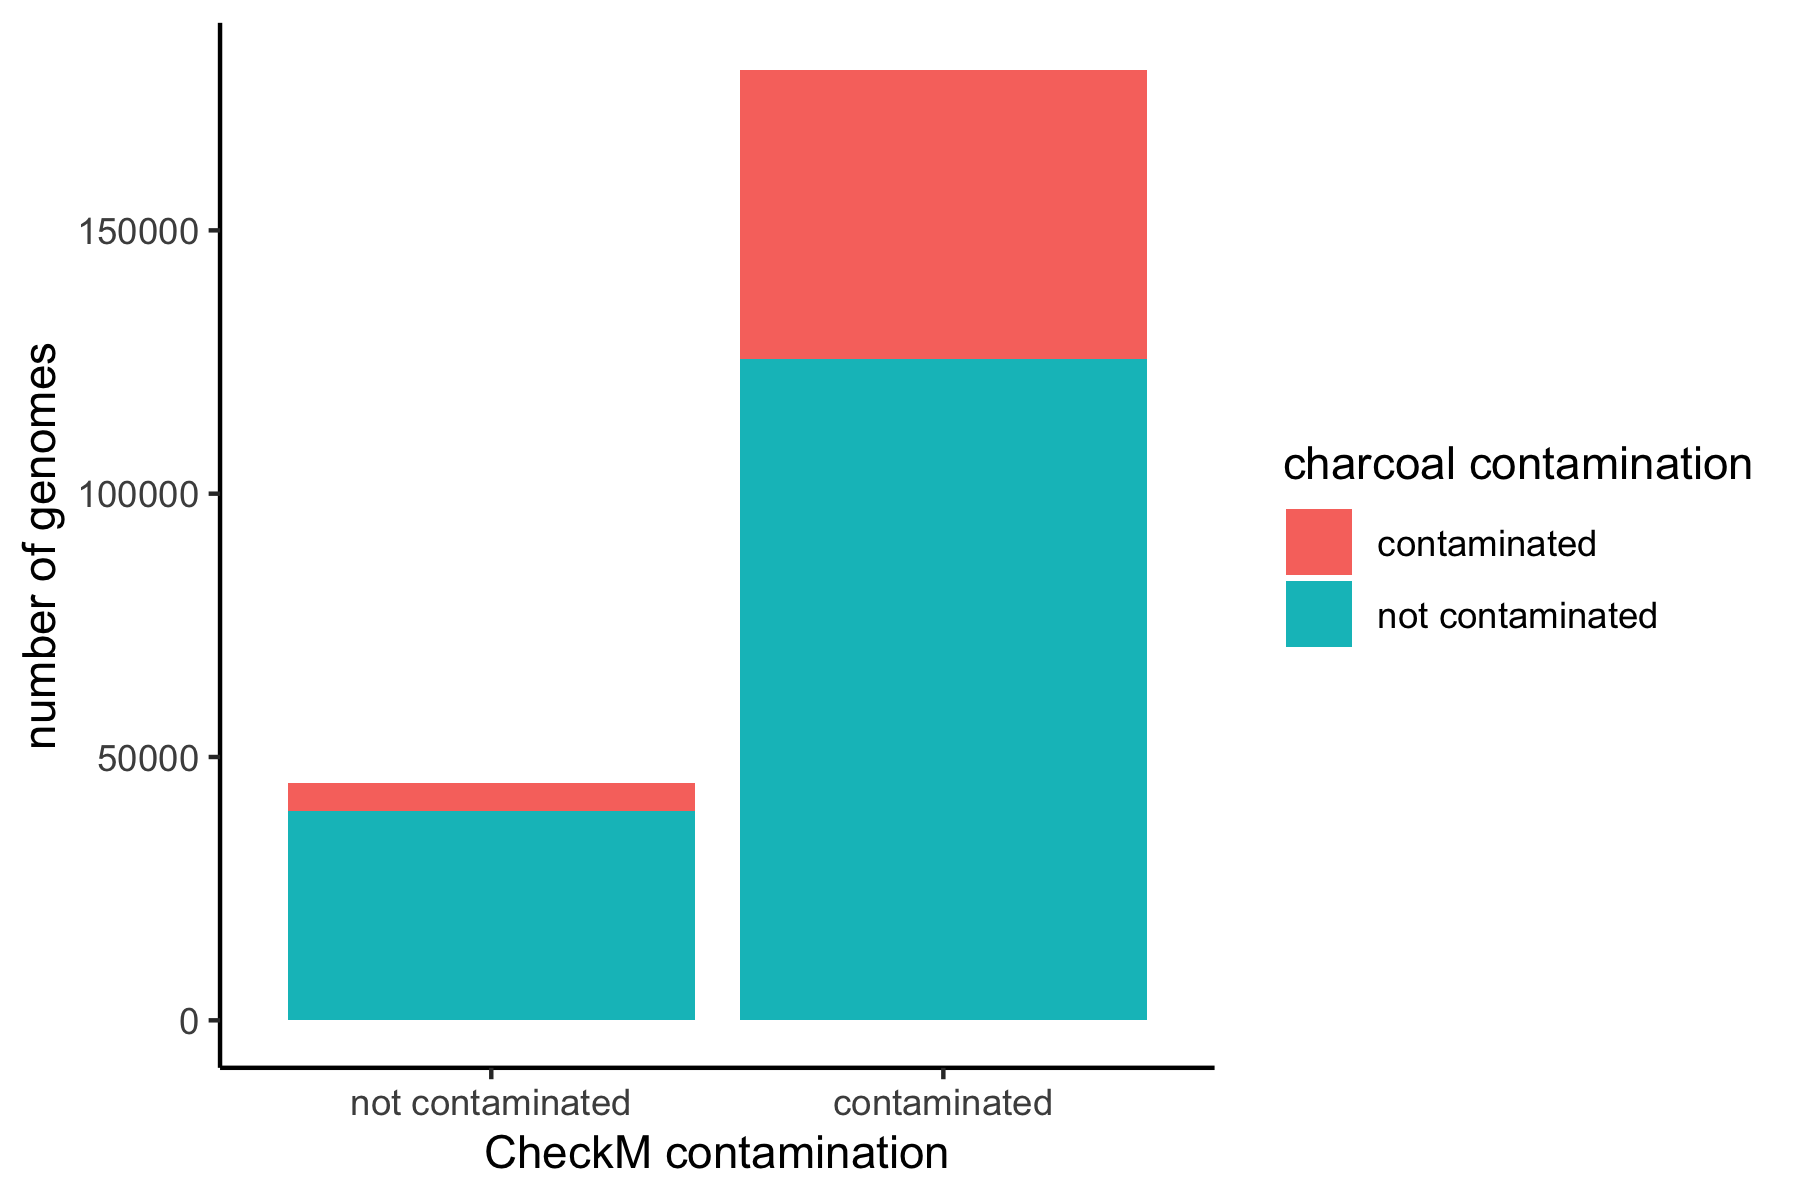

In [11]:
combined %>%
  group_by(contaminated_at_filter_rank, contaminated_with_checkm) %>%
  tally() %>%
  ggplot(aes(fill = contaminated_at_filter_rank, 
             y = n,
             x = contaminated_with_checkm)) +
    geom_col() +
    theme_classic() +
    labs(fill = "charcoal contamination", x = "CheckM contamination", y = "number of genomes") +
    scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
    scale_x_discrete(labels = c("FALSE" = "not contaminated", "TRUE" = "contaminated"))

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 170631 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 170631 rows containing non-finite values (stat_smooth).”


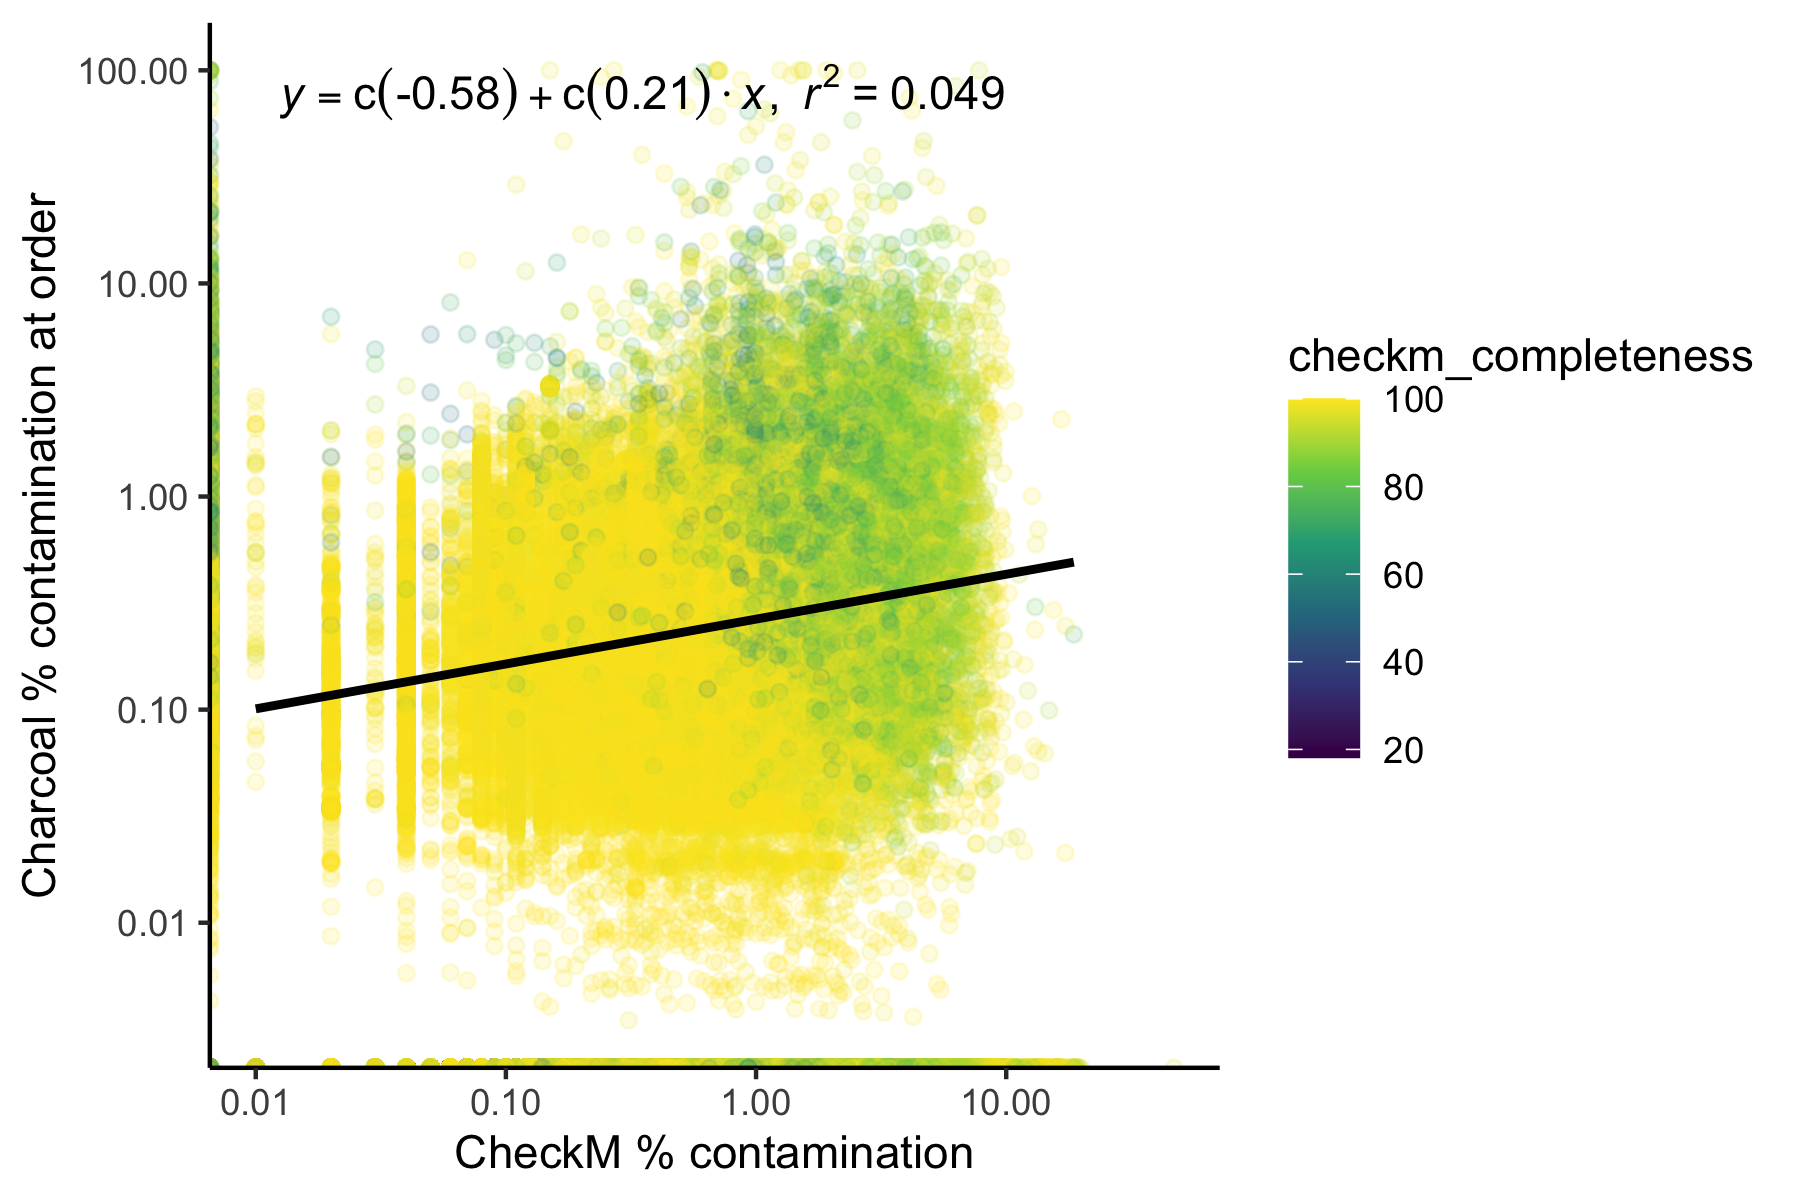

In [13]:
ggplot(combined, aes(x = checkm_contamination, y = charcoal_pct_contamination_order, color = checkm_completeness)) +
  geom_point(alpha = 0.15) +
  theme_classic() +
  scale_y_log10() +
  scale_x_log10() +
  scale_color_viridis_c()  +
  stat_smooth_func(geom = 'text', method = 'lm', hjust = 0, parse = T) +
  geom_smooth(method = "lm", se=FALSE, color="black", formula = y ~ x) +
  labs(x = "CheckM % contamination", y = "Charcoal % contamination at order")

## At what percent checkm contamination is there the highest overlap with charcoal contamination?

In [65]:
checkm_contam_pct_range <- seq(min(combined$checkm_contamination), max(combined$checkm_contamination), by = 0.01)

In [66]:
checkm_contam_vs_charcoal_contam_at_thresholds <- data.frame()
for(i in 1:length(checkm_contam_pct_range)){
    threshold <- checkm_contam_pct_range[i]
    checkm_tmp <- combined %>%
      mutate(contaminated_with_checkm_threshold = ifelse(checkm_contamination > threshold, T, F),
             threshold = threshold) %>%  
      group_by(contaminated_at_filter_rank, contaminated_with_checkm_threshold, threshold) %>%
      tally()
    checkm_contam_vs_charcoal_contam_at_thresholds <- bind_rows(checkm_contam_vs_charcoal_contam_at_thresholds, checkm_tmp)
}

Warning message:
“Removed 6339 rows containing missing values (geom_point).”


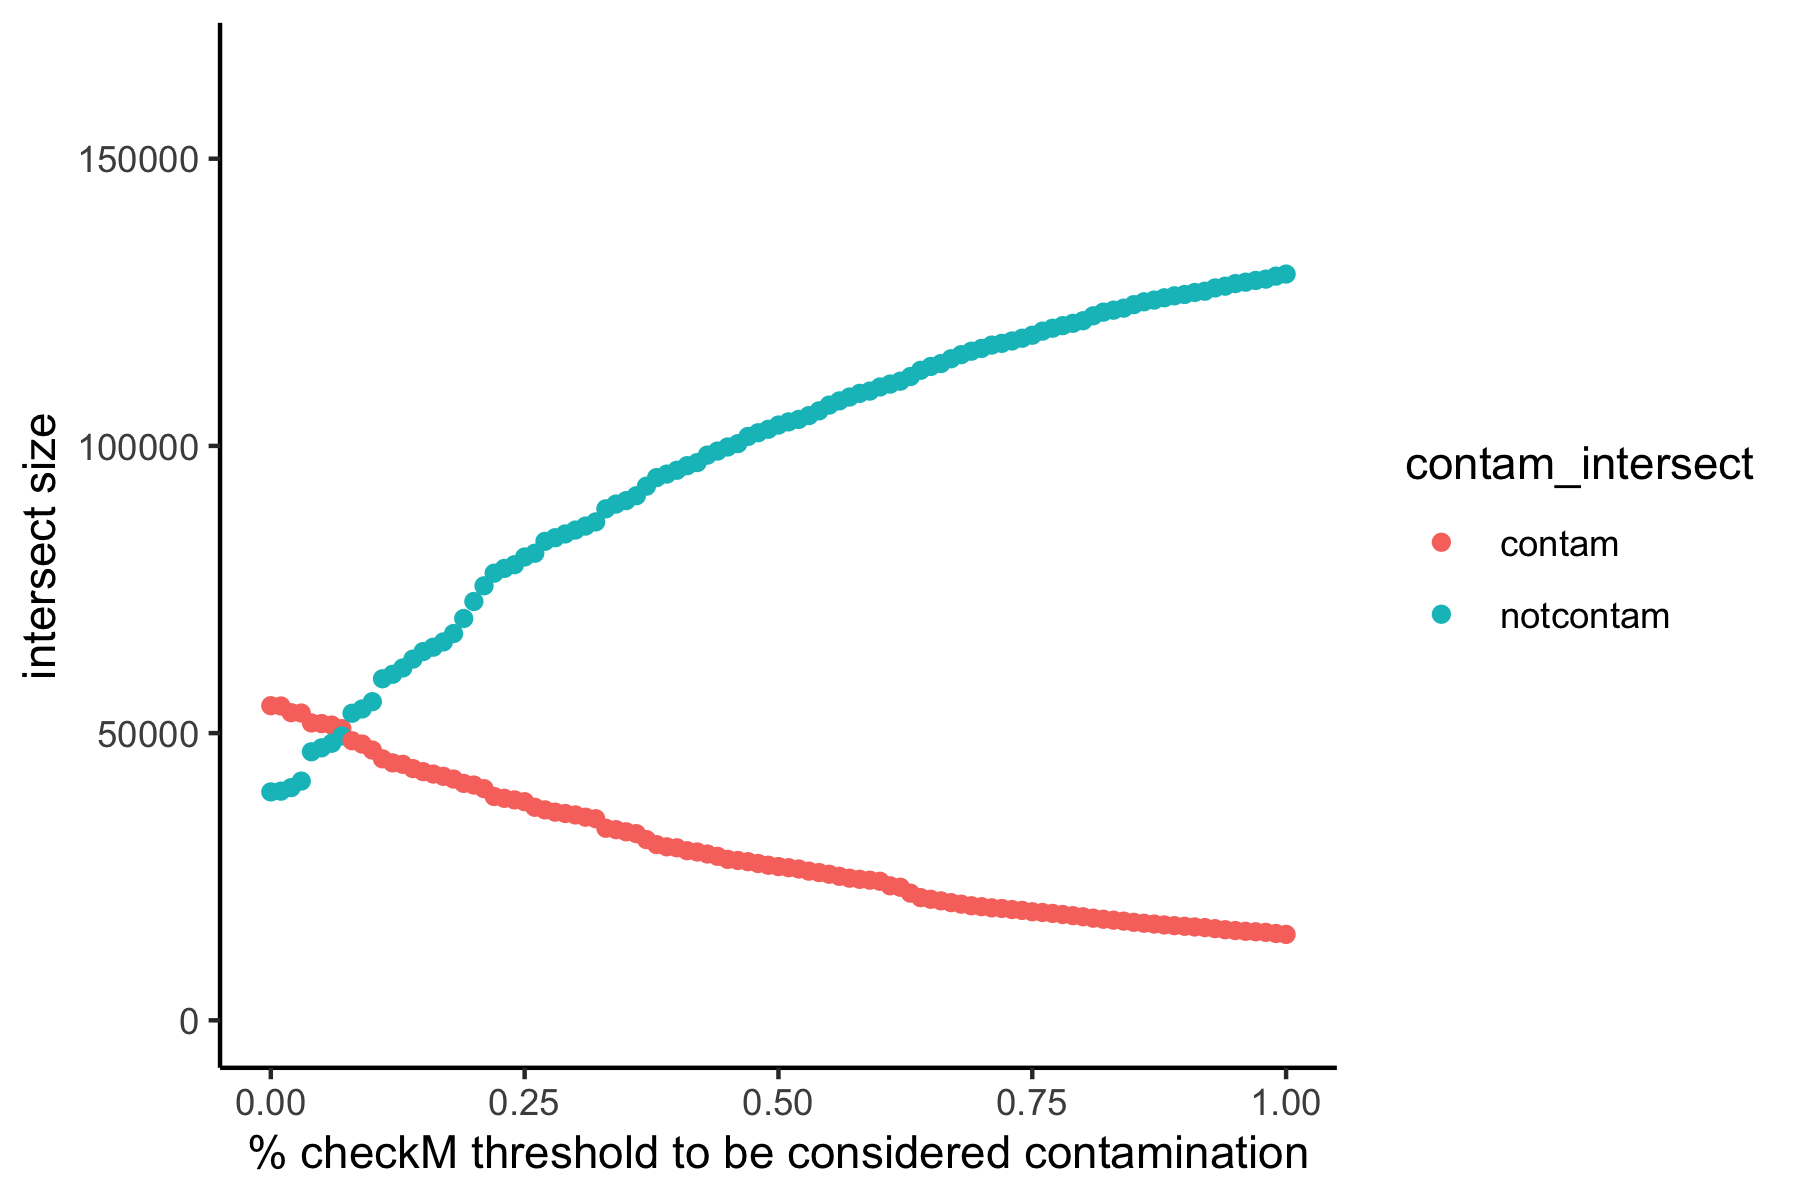

In [67]:
tmp <- checkm_contam_vs_charcoal_contam_at_thresholds %>%
  mutate(contam_intersect = ifelse(contaminated_at_filter_rank == TRUE & contaminated_with_checkm_threshold == TRUE, "contam", NA),
         contam_intersect = ifelse(contaminated_at_filter_rank == FALSE & contaminated_with_checkm_threshold == FALSE, "notcontam", contam_intersect)) %>%
  filter(!is.na(contam_intersect))
        

ggplot(tmp, aes(x = threshold, y = n, color = contam_intersect)) +
  geom_point() +
  theme_classic() +
  labs(x = "% checkM threshold to be considered contamination",
       y = "intersect size") +
  xlim(0, 1)

In [28]:
nrow(combined)

[1] 225400

In [29]:
tmp <- checkm_contam_vs_charcoal_contam_at_thresholds %>%
         filter(contaminated_at_filter_rank == FALSE) %>%
         filter(contaminated_with_checkm_threshold == FALSE)

max(tmp$n)

[1] 165382

In [42]:
combined <- combined %>%
  mutate(contaminated_with_checkm_threshold = ifelse(checkm_contamination > 0.07, T, F))

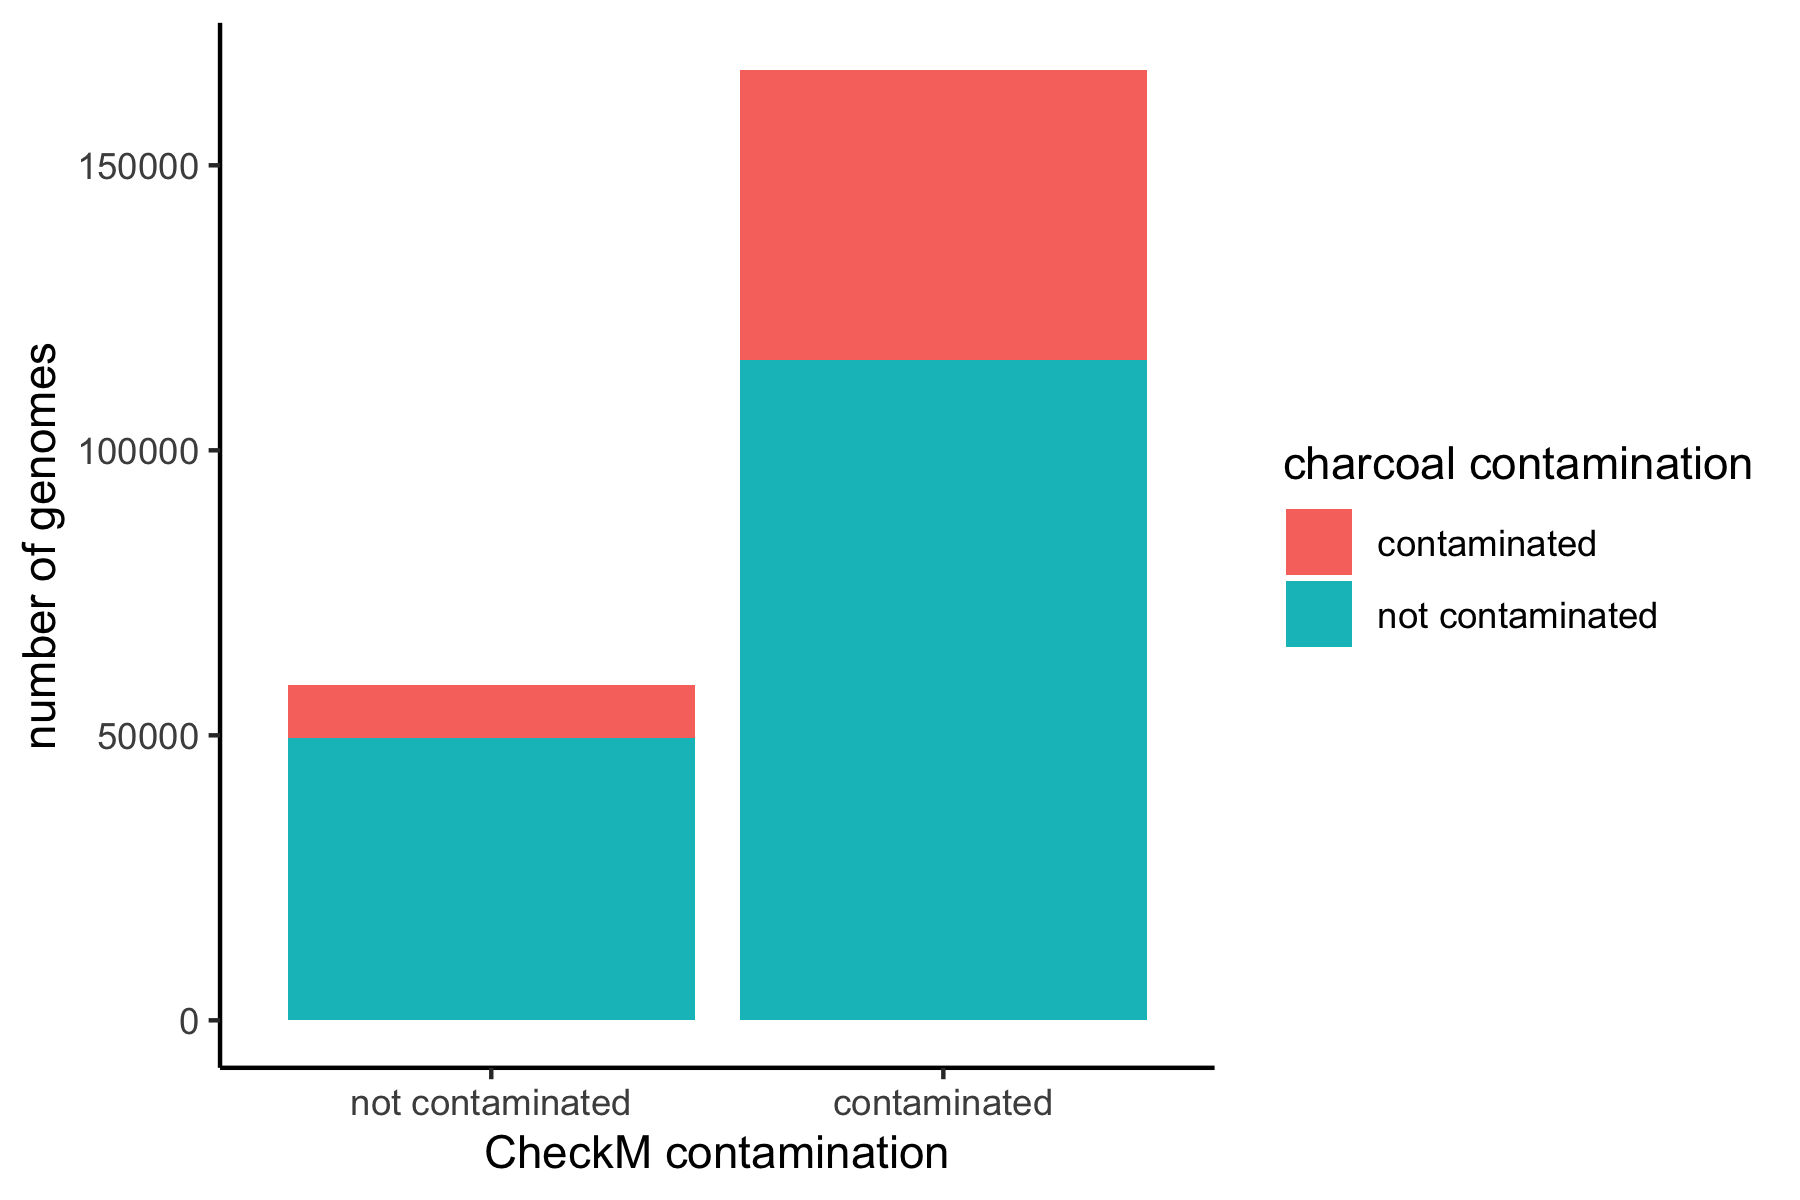

In [44]:
combined %>%
  group_by(contaminated_at_filter_rank, contaminated_with_checkm_threshold) %>%
  tally() %>%
  ggplot(aes(fill = contaminated_at_filter_rank, 
             y = n,
             x = contaminated_with_checkm_threshold)) +
    geom_col() +
    theme_classic() +
    labs(fill = "charcoal contamination", x = "CheckM contamination", y = "number of genomes") +
    scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
    scale_x_discrete(labels = c("FALSE" = "not contaminated", "TRUE" = "contaminated"))

In [45]:
combined %>%
  group_by(contaminated_at_filter_rank, contaminated_with_checkm_threshold) %>%
  tally()

contaminated_at_filter_rank,contaminated_with_checkm_threshold,n
<fct>,<lgl>,<int>
TRUE,FALSE,9237
TRUE,TRUE,50780
FALSE,FALSE,49503
FALSE,TRUE,115880


## Do thresholding again, but at family level

In [52]:
checkm_contam_vs_charcoal_contam_family_at_thresholds <- data.frame()
for(i in 1:length(checkm_contam_pct_range)){
    threshold <- checkm_contam_pct_range[i]
    checkm_tmp <- combined %>%
      mutate(contaminated_with_checkm_threshold = ifelse(checkm_contamination > threshold, T, F),
             threshold = threshold) %>%  
      group_by(contaminated_at_family, contaminated_with_checkm_threshold, threshold) %>%
      tally()
    checkm_contam_vs_charcoal_contam_family_at_thresholds <- bind_rows(checkm_contam_vs_charcoal_contam_family_at_thresholds, checkm_tmp)
}

Warning message:
“Removed 6589 rows containing missing values (geom_point).”


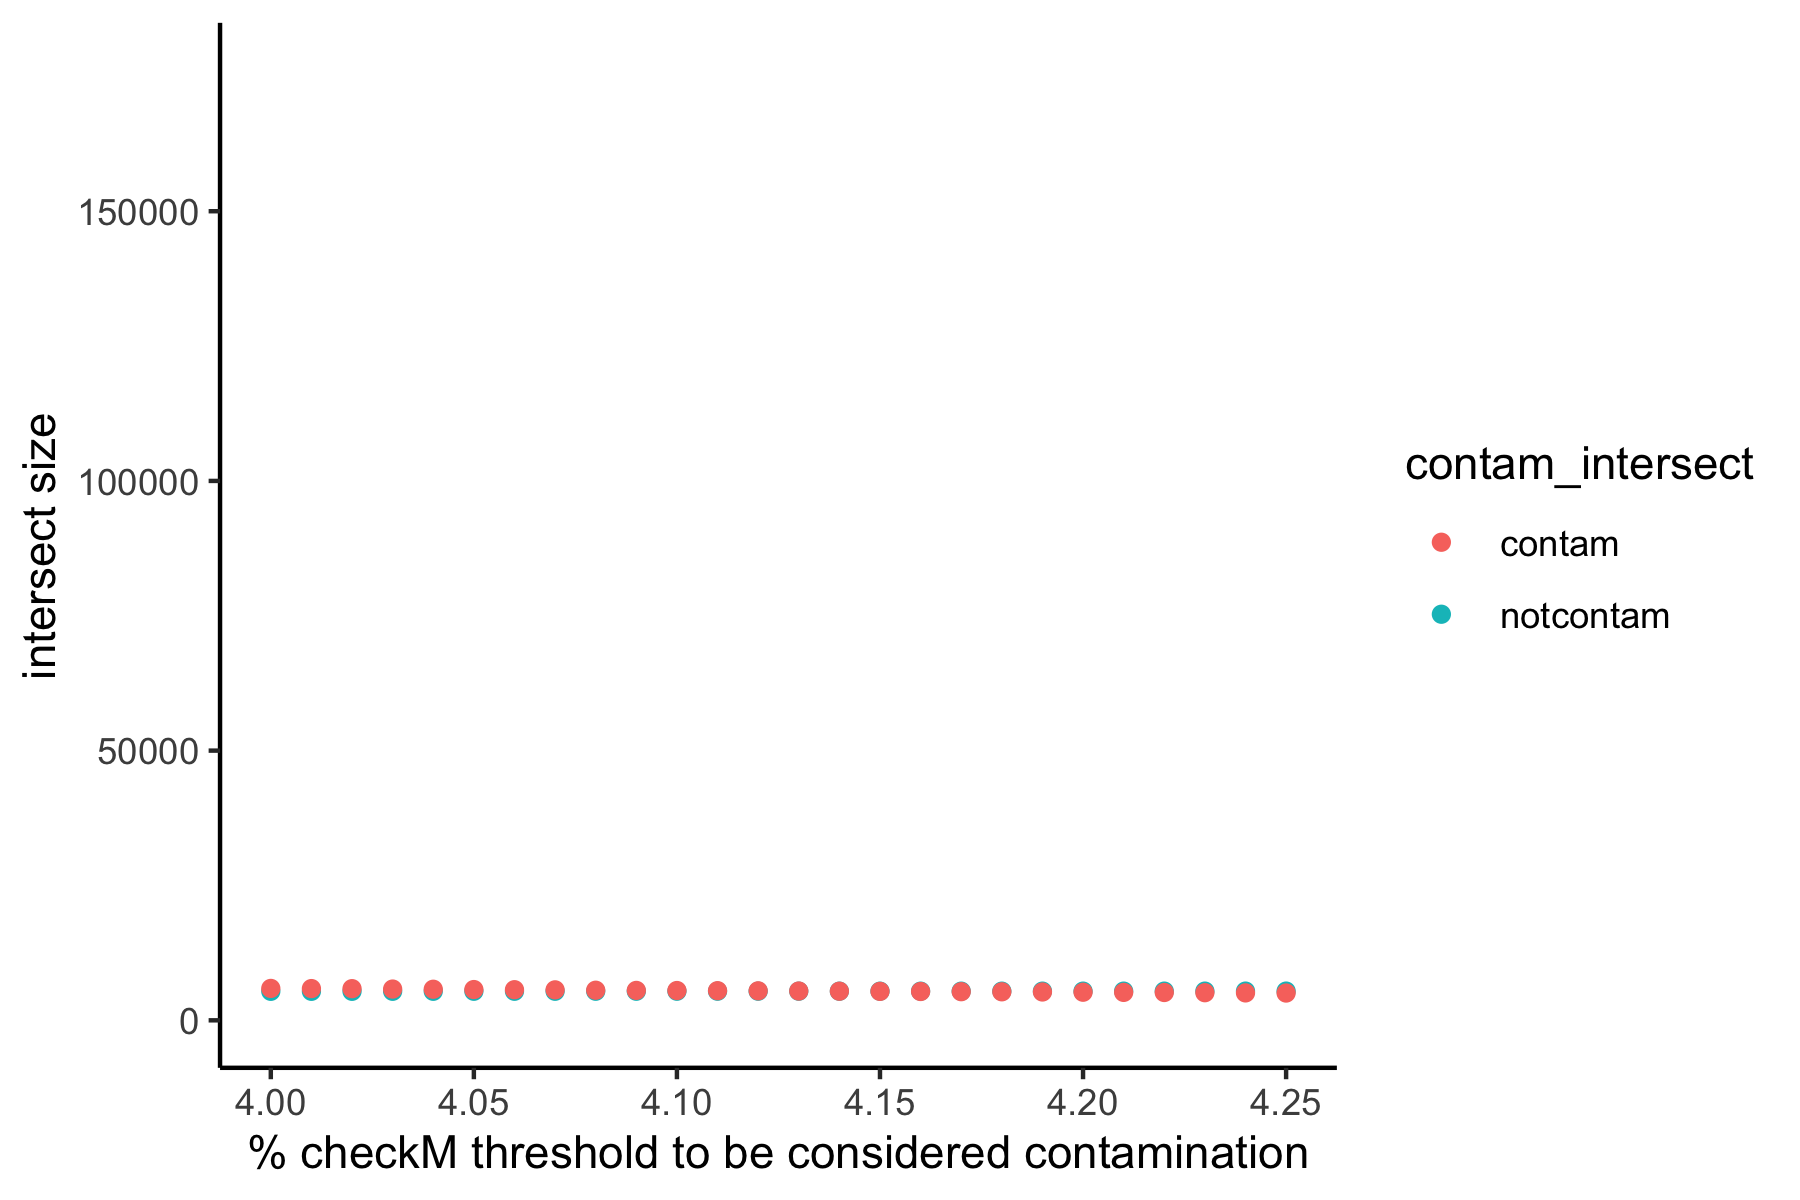

In [59]:
tmp <- checkm_contam_vs_charcoal_contam_family_at_thresholds %>%
  mutate(contam_intersect = ifelse(contaminated_at_family == TRUE & contaminated_with_checkm_threshold == TRUE, "contam", NA),
         contam_intersect = ifelse(contaminated_at_family == FALSE & contaminated_with_checkm_threshold == FALSE, "notcontam", contam_intersect)) %>%
  filter(!is.na(contam_intersect))
        

ggplot(tmp, aes(x = threshold, y = n, color = contam_intersect)) +
  geom_point() +
  theme_classic() +
  labs(x = "% checkM threshold to be considered contamination",
       y = "intersect size") +
  xlim(4, 4.25)

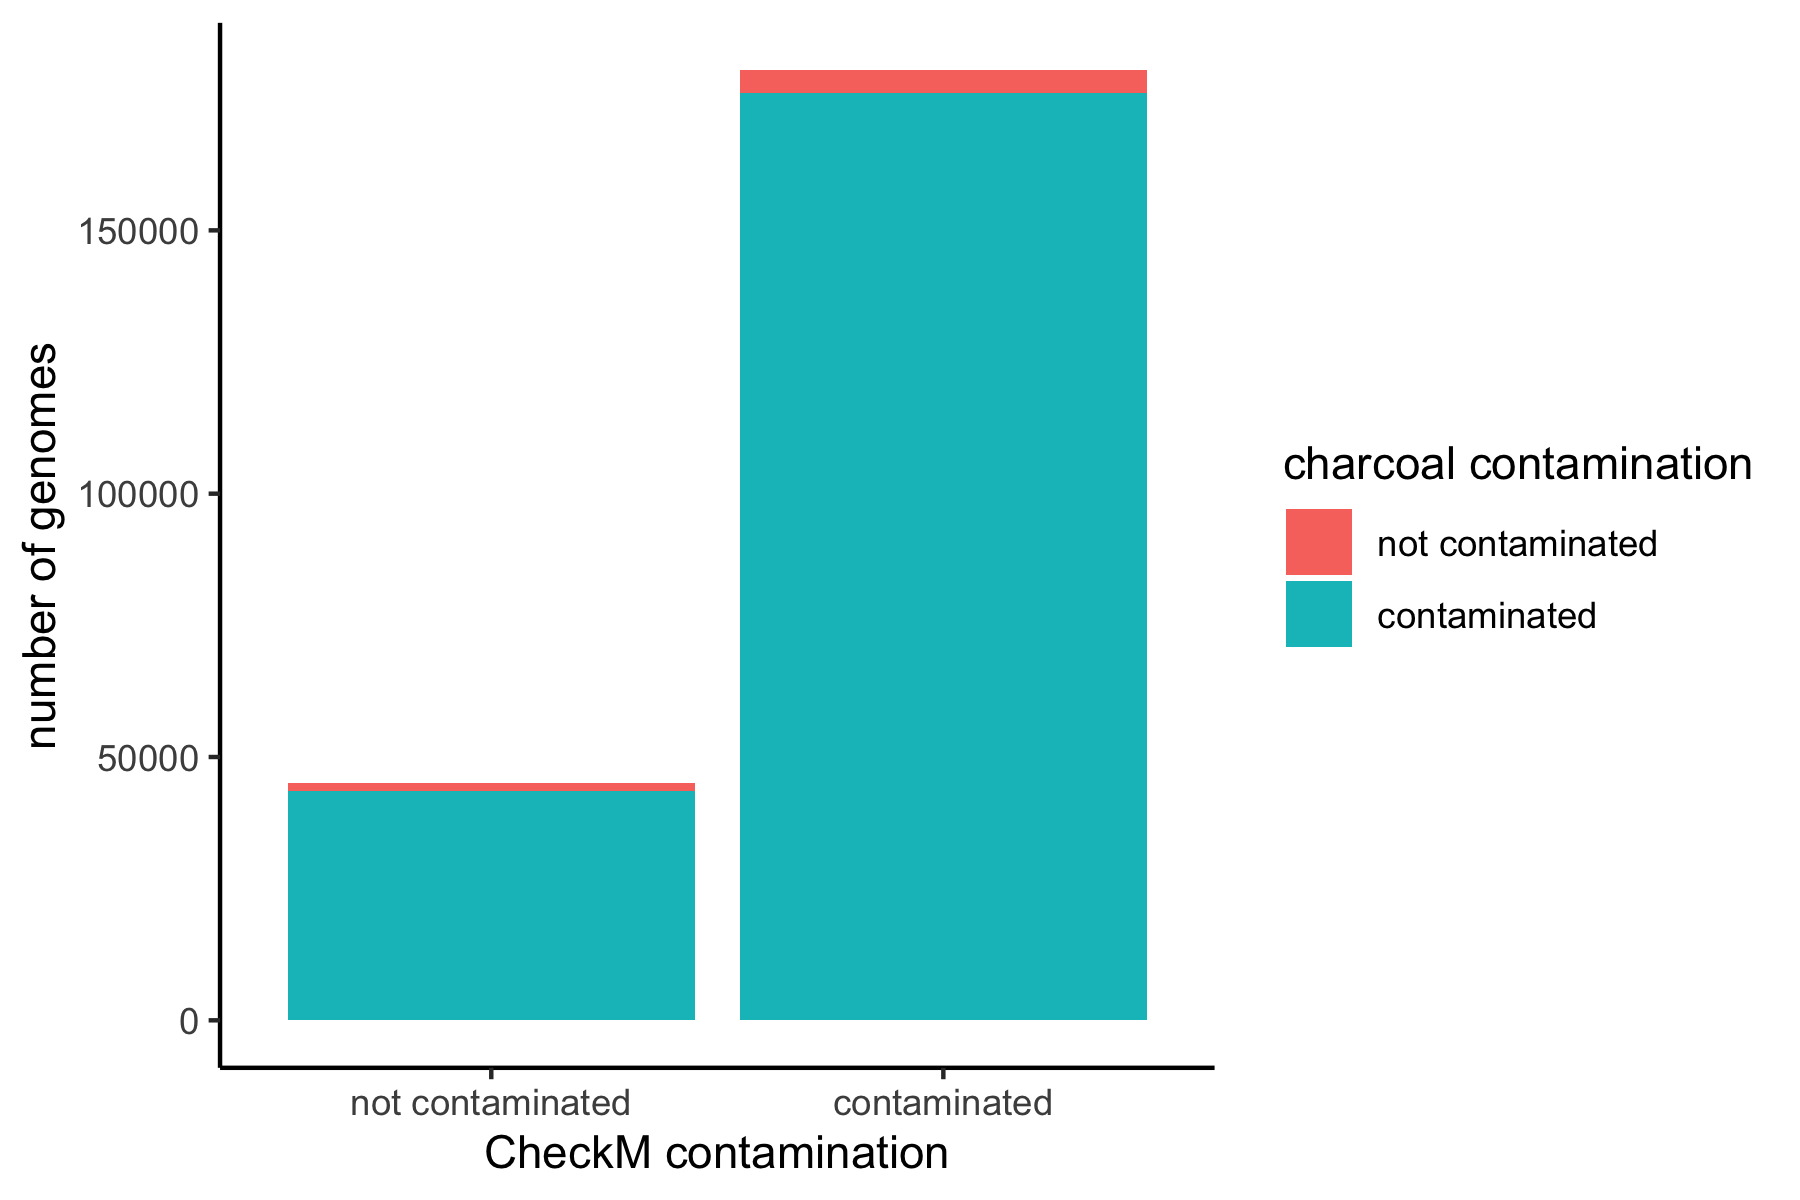

In [62]:
combined %>%
  group_by(contaminated_at_family, contaminated_with_checkm) %>%
  tally() %>%
  ggplot(aes(fill = contaminated_at_family, 
             y = n,
             x = contaminated_with_checkm)) +
    geom_col() +
    theme_classic() +
    labs(fill = "charcoal contamination", x = "CheckM contamination", y = "number of genomes") +
    scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
    scale_x_discrete(labels = c("FALSE" = "not contaminated", "TRUE" = "contaminated"))

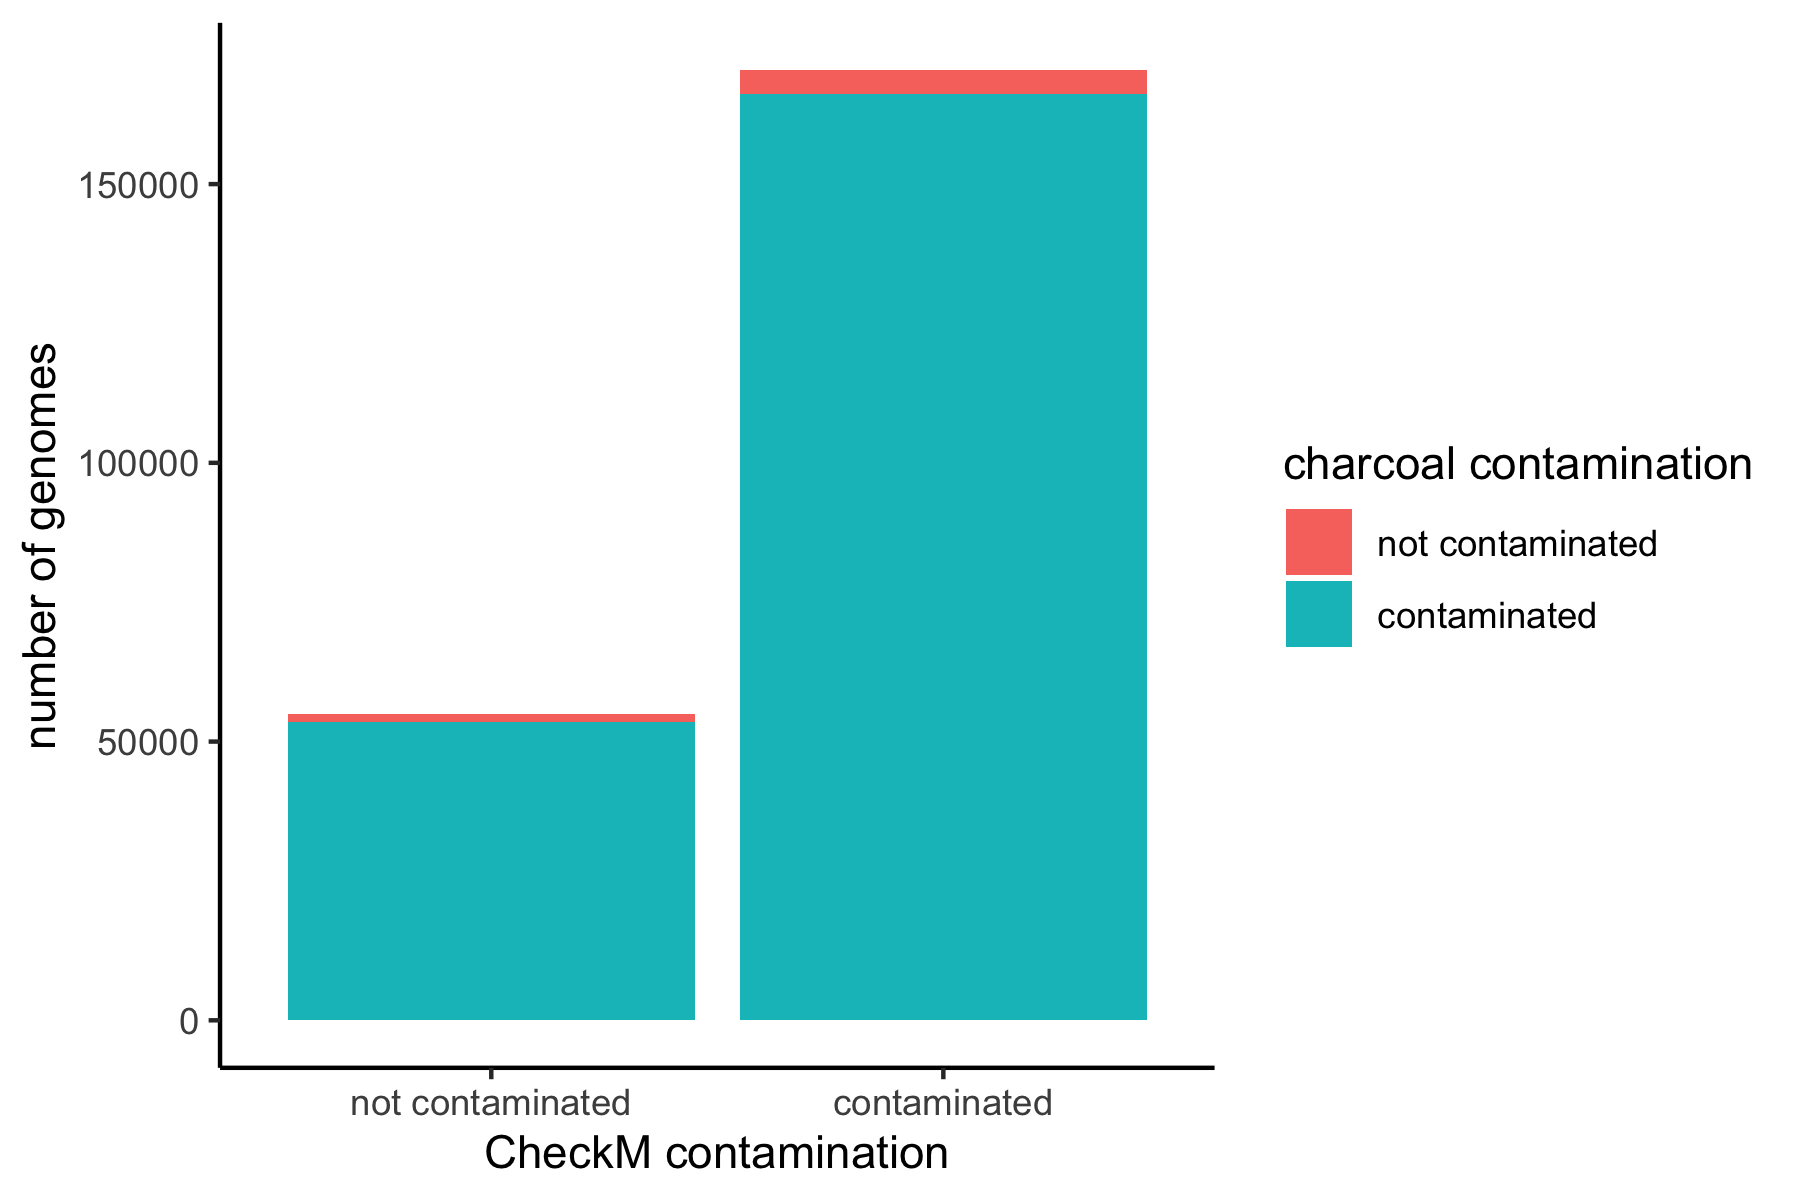

In [63]:
combined <- combined %>%
  mutate(contaminated_with_checkm_threshold = ifelse(checkm_contamination > 0.041, T, F))

combined %>%
  group_by(contaminated_at_family, contaminated_with_checkm_threshold) %>%
  tally() %>%
  ggplot(aes(fill = contaminated_at_family, 
             y = n,
             x = contaminated_with_checkm_threshold)) +
    geom_col() +
    theme_classic() +
    labs(fill = "charcoal contamination", x = "CheckM contamination", y = "number of genomes") +
    scale_fill_discrete(labels=c("FALSE" = "not contaminated", "TRUE" = "contaminated")) +
    scale_x_discrete(labels = c("FALSE" = "not contaminated", "TRUE" = "contaminated"))